In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
import os

In [ ]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')


In [ ]:
# ตรวจสอบว่า TensorFlow ใช้ GPU หรือไม่
import tensorflow as tf

# ตรวจสอบจำนวน GPU ที่ใช้ได้
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    # ตั้งค่าการใช้ GPU T4 (หรือ GPU ตัวอื่นที่มี)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # ใช้ memory growth เพื่อการใช้ GPU อย่างมีประสิทธิภาพ
    print(f"✅ ใช้ GPU: {gpus}")
else:
    print("❌ ไม่พบ GPU")

# ตรวจสอบว่าใช้งาน GPU T4 ได้หรือไม่
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


✅ ใช้ GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8167369977817116265
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5982829880684823645
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# แสดงโฟลเดอร์และไฟล์ใน Google Drive
drive_path = '/content/drive/MyDrive/Colab_Notebooks/train/train'
print(os.listdir(drive_path))


['.DS_Store', 'surprise', 'happy', 'fear', 'disgust', 'sad', 'neutral', 'angry']


In [ ]:
import os

# เส้นทางโฟลเดอร์ใน Google Drive
dataset_path = '/content/drive/MyDrive/Colab_Notebooks/train/train'

# อ่านไฟล์ในโฟลเดอร์
files = os.listdir(dataset_path)
print(files)


['.DS_Store', 'surprise', 'happy', 'fear', 'disgust', 'sad', 'neutral', 'angry']


In [ ]:
import os
import pandas as pd

dataset_path = "/content/drive/MyDrive/Colab_Notebooks/train/train"  # เปลี่ยนเป็น path ที่แท้จริงของคุณ

data = []
for emotion in os.listdir(dataset_path):
    emotion_path = os.path.join(dataset_path, emotion)
    if os.path.isdir(emotion_path):  # เช็คว่าเป็นโฟลเดอร์
        for img_name in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_name)
            data.append([img_name, emotion])  # บันทึกชื่อไฟล์ + อารมณ์

# สร้าง DataFrame และบันทึกเป็น CSV
df = pd.DataFrame(data, columns=["Image name", "Emotion"])
df.to_csv("metadata.csv", index=False)

print(df.head())  # แสดงตัวอย่างข้อมูล


              Image name   Emotion
0  Training_63356241.jpg  surprise
1  Training_43243439.jpg  surprise
2  Training_30285694.jpg  surprise
3  Training_58183233.jpg  surprise
4  Training_63778502.jpg  surprise


In [ ]:
df

,Image name,Emotion
0,Training_63356241.jpg,surprise
1,Training_43243439.jpg,surprise
2,Training_30285694.jpg,surprise
3,Training_58183233.jpg,surprise
4,Training_63778502.jpg,surprise
...,...,...
21404,Training_13919685.jpg,angry
21405,Training_27379882.jpg,angry
21406,Training_14227929.jpg,angry
21407,Training_10315441.jpg,angry


In [ ]:
unique_emotions = df['Emotion'].unique()
print(unique_emotions)

['surprise' 'happy' 'fear' 'disgust' 'sad' 'neutral' 'angry']


In [ ]:
emotion_counts = df['Emotion'].value_counts()
print(emotion_counts)


Emotion
neutral     4312
sad         3838
angry       3526
surprise    3115
happy       3098
fear        3084
disgust      436
Name: count, dtype: int64


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# กำหนดโฟลเดอร์หลักที่เก็บรูปภาพ
dataset_path = "/content/drive/MyDrive/Colab_Notebooks/train/train"  # เปลี่ยนเป็น path จริงของคุณ

X, y = [], []
categories = sorted(os.listdir(dataset_path))  # อ่านโฟลเดอร์ (แต่ละโฟลเดอร์เป็นอารมณ์)

# วนลูปโหลดภาพ
for emotion in categories:
    emotion_path = os.path.join(dataset_path, emotion)

    if os.path.isdir(emotion_path):  # เช็คว่าเป็นโฟลเดอร์จริงๆ
        for img_name in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_name)

            # โหลดรูปภาพแบบ Grayscale และปรับขนาดเป็น 48x48
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (48, 48))  # Resize ภาพ
                X.append(img)
                y.append(emotion)  # บันทึกอารมณ์ที่สัมพันธ์กับภาพ

# แปลงเป็น NumPy Array
X = np.array(X).reshape(-1, 48, 48, 1)  # ทำให้เป็น 4D Tensor
X = X / 255.0  # Normalize ค่าให้อยู่ในช่วง 0-1

# แปลง Label เป็น One-Hot Encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # แปลงอารมณ์เป็นตัวเลข
y = to_categorical(y)  # แปลงเป็น One-Hot

print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")  # ตรวจสอบขนาดข้อมูล
print(f"Classes: {label_encoder.classes_}")  # แสดงชื่อคลาส


Shape of X: (22467, 48, 48, 1), Shape of y: (22467, 7)
Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [ ]:
from sklearn.model_selection import train_test_split

# แบ่งข้อมูล 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train data: {X_train.shape}, Test data: {X_test.shape}")


Train data: (17973, 48, 48, 1), Test data: (4494, 48, 48, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# สร้างโครงสร้าง CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 คลาสของอารมณ์
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()  # ดูโครงสร้างโมเดล


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)


Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.2160 - loss: 1.8459 - val_accuracy: 0.3182 - val_loss: 1.6915
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3390 - loss: 1.6652 - val_accuracy: 0.4239 - val_loss: 1.5227
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4172 - loss: 1.5144 - val_accuracy: 0.4535 - val_loss: 1.4264
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4646 - loss: 1.4059 - val_accuracy: 0.4760 - val_loss: 1.3889
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4970 - loss: 1.3415 - val_accuracy: 0.4871 - val_loss: 1.3519
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5164 - loss: 1.2717 - val_accuracy: 0.5125 - val_loss: 1.3043
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5343 - loss: 1.2431 - val_accuracy: 0.5151 - val_loss: 1.2916
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5503 - loss: 1.1854 - val_accuracy: 

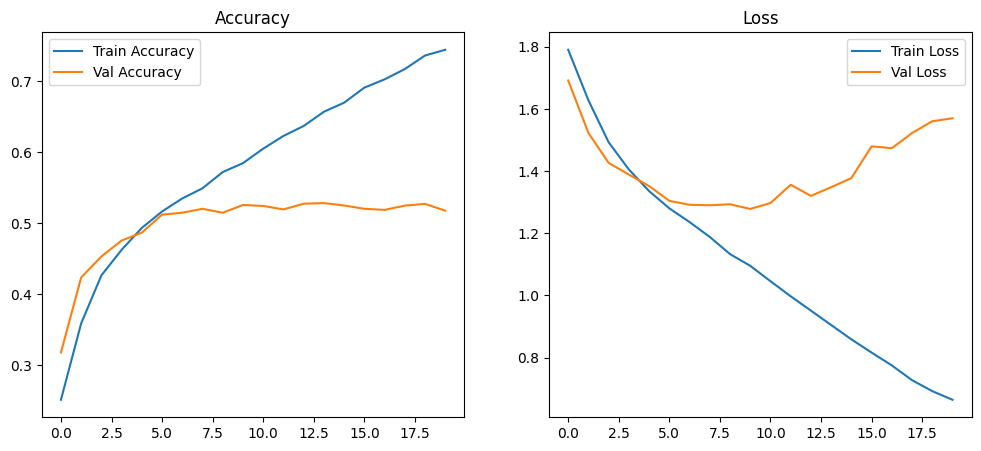

In [ ]:
import matplotlib.pyplot as plt

# แสดงกราฟ Accuracy และ Loss
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"📊 Test Accuracy: {test_acc*100:.2f}%")


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5302 - loss: 1.5659
📊 Test Accuracy: 51.80%


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer

# เพิ่ม Custom Layer
class CastLayer(Layer):
    def call(self, inputs):
        return inputs

def load_emotion_model():
    model_path = "path/to/emotion_modelNue.h5"  # ตรวจสอบ path ให้ถูกต้อง
    model = load_model(model_path, custom_objects={"Cast": CastLayer})  # แก้ให้รู้จัก 'Cast'
    return model
